In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns

np.random.seed(42)

In [2]:
penguins = pd.read_csv("data/penguins.csv")
# удалим пропущенные данные
penguins = penguins.dropna(axis=0)

penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [3]:
penguins.pivot_table(index='species', values='body_mass_g', aggfunc = ["mean", "std", "count"])

,mean,std,count
,body_mass_g,body_mass_g,body_mass_g
species,,,
Adelie,3706.164384,458.620135,146
Chinstrap,3733.088235,384.335081,68
Gentoo,5092.436975,501.476154,119


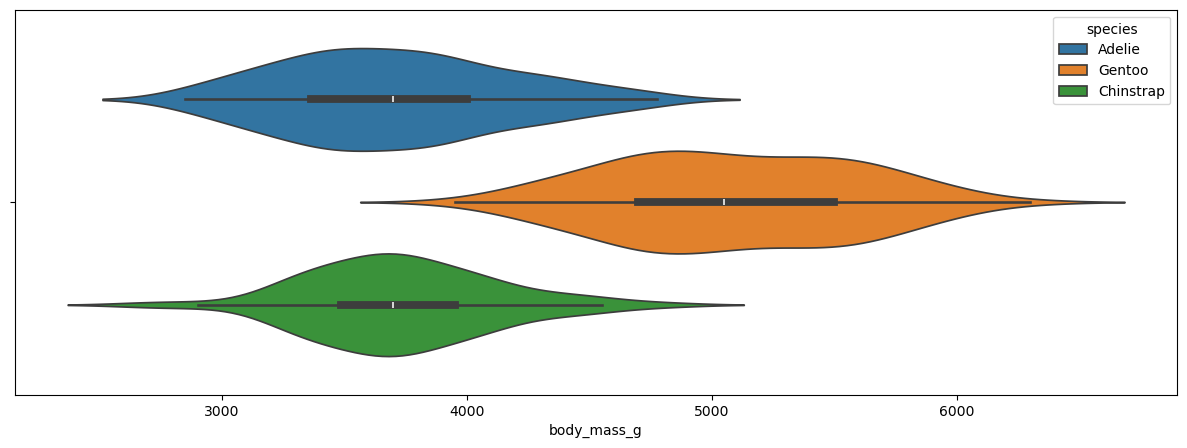

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
sns.violinplot(data=penguins, x='body_mass_g',hue ='species', ax=ax);

Теперь у нас есть точечные оценки как средних значений и дисперсии. Также полезно посмотреть как выглядят гистограммы по нашим данным.

Одним из способов получить оценки неопределенности является использование байесовских методов.

Поскольку у нас нет конкретной причины выбирать информативное априорное распределение, то мы будем достаточно "широкие" распределения для обоих $\mu$ и $\sigma$. 

В данном случае априорные выбираются на основе эмпирического среднего и стандартного отклонения наблюдаемых данных. 

Давайте пока не будем искать вес всех видов пингвинов, а сначала начнем с веса пингвинов вида  Adelie. Нормальное распределение - это разумный выбор плотности распределения вероятности для веса пингвина и веса биологического объекта в целом, поэтому мы используем его. 

Давайте переведем уравнение (3.1) в вычислительную модель.

$$\overbrace{p(\mu, \sigma \mid Y)}^\text{Апостериорное} 
\propto \overbrace{\mathcal{N}(Y \mid \mu, \sigma)}^\text{Правбоподобие}\;  
\overbrace{\underbrace{\mathcal{N}(4000, 3000)}_{\mu}
     \underbrace{\mathcal{H}\text{T}(100, 2000)}_{\sigma}}^\text{Априорное}$$

In [7]:
adelie_mask = penguins["species"] == "Adelie"
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    # priop априорные распределения
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    # likehood правдоподобие
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)
    # найдем апостерионое распределение
    idata_adelie_mass = pm.sample(chains=4)
    # сгенерируем дополнительные веса пингвинов для априорных распределений
    idata_adelie_mass.extend(pm.sample_prior_predictive(samples=5000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [mass, μ, σ]


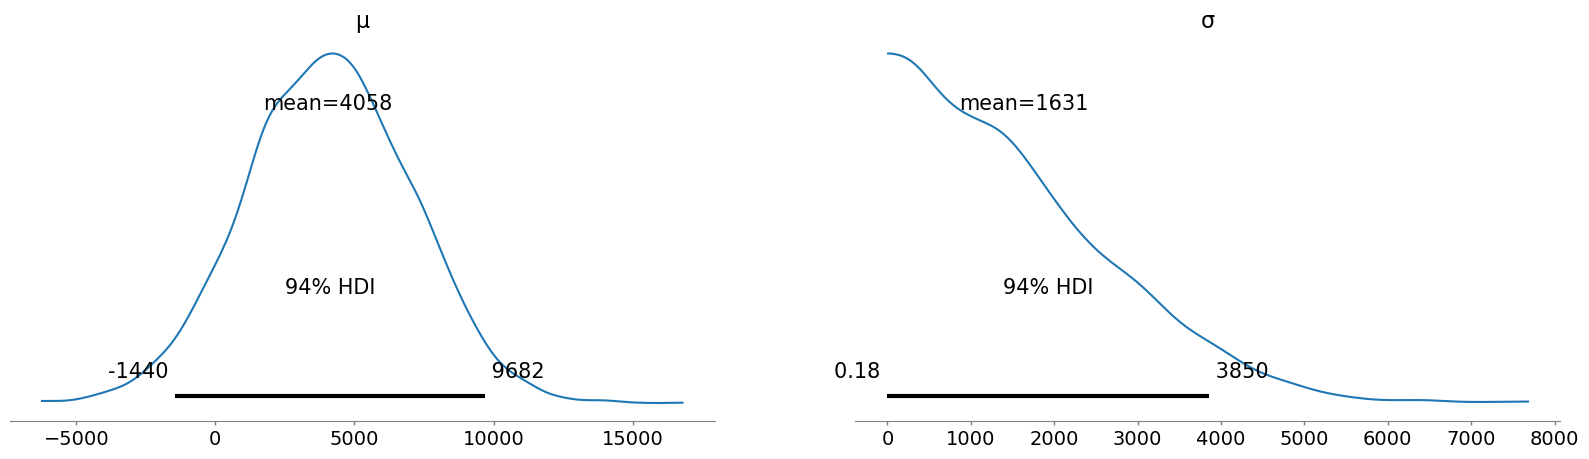

In [8]:
# важно не какое название функции а на каких данных она построена !!!!!
axes = az.plot_posterior(idata_adelie_mass.prior, var_names=["μ", "σ"], figsize=(20, 5))

Прежде, чем начать анализировать апостериорное распределение, мы проверим преидущие шаги.

В данном случае, мы сначала проверяем: 
- является ли данные, на которой мы строим нашу модель  вычислительно осуществимимы и что
- является ли наш выбор априорного распределения является разумным, основанным на наших знаниях в области. 

Наша модель не имеет «очевидных» вычислительных проблем, таких как проблемы с неправильно заданной плотностью распределения, неправильно определенные случайные переменные или их вероятности. Обэтом нам говорит параметр `0 divergences` в семлинге.

Далее мы получим графих априоного распределения использованного в нашей модели. Из самих априорных графиков очевидно, что мы не слишком ограничиваем возможные веса пингвино. На самом деле мы можем дать более сильное ограничение, поскольку априорное распределение для среднего значения веса пингвина включает в себя отрицательные значения. 

Однако, поскольку это простая модель, и у нас есть приличное количество наблюдений, мы просто отметим эту "особенность" и перейдем к оценке апостериорного распределения.

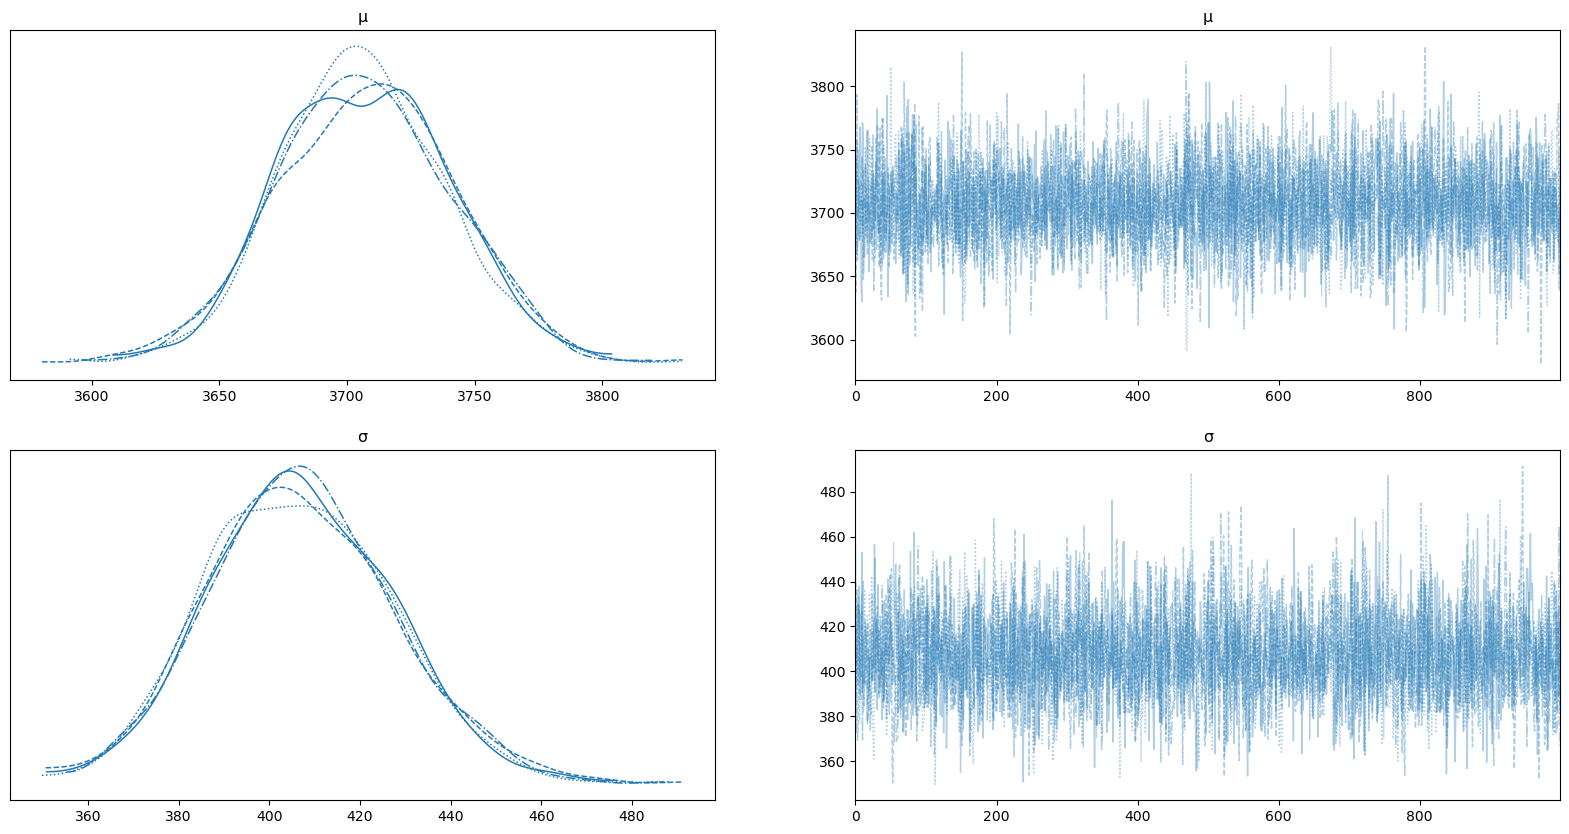

In [10]:
axes = az.plot_trace(idata_adelie_mass, figsize=(20, 10))
### можно сохранить картинку в файл  
#plt.savefig("idata_adelie_mass_trace.png")

`plot_trace` вероятно, являются самыми популярными графиками в байесовской литературе. Они часто являются первым графиком, который мы создаем после вывода, чтобы визуально проверить то, что мы получили. 

График трассировки составляется путем построения плотности вероятности для каждой цепочки. На этих графиках мы должны увидеть, сходятся ли разные цепи в одно и то же распределение, мы можем получить представление о степени автокорреляции. 

Как визуально понять степень "хорошести" результата. Давайте посмотрим ниже на три примера:
!["img/trace_plots.png"](img/trace_plots.png)

В левой части мы видим по одному KDE (ядерному методу оценки плотности непараметрического распределения) на цепочку. 
В правой части мы видим значения сэмплов для каждой цепочки на каждом шаге. Обратите внимание на различия в графиках KDE и trace между каждой из цепочек примеров, в частности, "случайный" вид цепочках в "good_chains" по сравнению с "неровностями" в двух других случаях.

На приведенном примере видно `plot_trace` для хороших и плохих цепей, очень заметно, что события в "good_chains" принадлежат к одному и тому же распределению, так как между обеими цепочками есть лишь небольшие (случайные) различия. 
Когда мы видим семплы, упорядоченные по итерации (т.е. саму трассировку), мы видим, что цепи выглядят довольно "шумно" -- без видимой тенденций или шаблонов, также трудно отличить одну цепочку от другой. 

Это явно отличается от того, что мы получаем за "bad_chains0". 
Для этой выборки мы четко видим два разных распределения с лишь небольшим перекрытием. Это легко увидеть как из KDE, так и из трассировки. 
Цепи фактически строят две разные области пространства сэмплов. 

Ситуация для "bad_chains1" немного более тонкая. KDE показывает распределения, которые кажутся похожими на те, что из "good_chains", различия между двумя цепочками менее очевидны. 

У нас есть несколько локальных максимумов? Распределения, похоже, не совпадают. Может быть, у нас есть только один максимум, и локальные максимумы - это артефакты? 

Несколько максимумов, как правило, выглядит подозрительно, если у нас нет оснований предпологать наличие мультимодальные распределения, возникающих, например, из подгрупп данных. 

Трассировка семплов, так же в некоторой степени похожа на трассировку из "good_chains", но более тщательный осмотр показывает наличие длинных областей монотонности. Это явное свидетельство того, что семплер застревает в некоторых областях пространства параметров, возможно, потому, что у нас есть мультимодальный апостериор с переключением между режимами очень низкой вероятности, или, возможно, потому, что у нас есть некоторые области пространства параметров с кривизной, которая слишком отличается от остальных.

Возможно сейчас нагляднее использовать в правой части не сэмплы, а ранговые графики. Ранговые графики - это еще одна визуальная диагностика, которую мы можем использовать для сравнения поведения выборки как внутри, так и между цепочками. Проще говоря, ранговые графики - это гистограммы ранжированных образцов. Ранги рассчитываются путем изначального объединения всех цепочек, а затем построения результатов отдельно для каждой цепочки. Если все цепочки нацелены на одно и то же распределение, мы ожидаем, что ранги будут иметь равномерное распределение. Кроме того, если ранговые графики всех цепей выглядят одинаково, это указывает на хорошую сходимость цепей

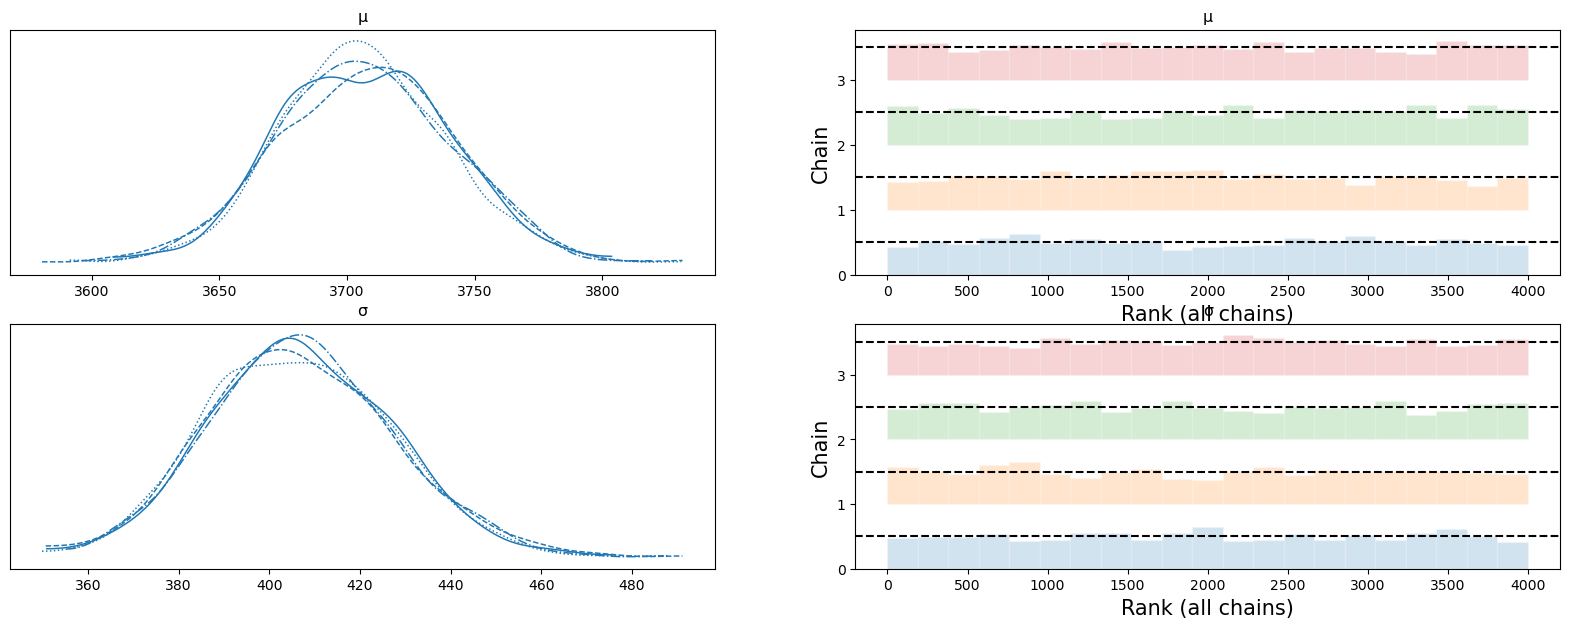

In [15]:
axes = az.plot_trace(idata_adelie_mass,  divergences="bottom", kind="rank_bars", figsize=(20, 7))

Давайте посмотрим ниже на три примера ранговых графиков:
!["img/rank_plot_bars.png"](img/rank_plot_bars.png)

Ранговые графики с использованием представления "bar". В частности, сравнивается высоту бара с пунктирной линией, представляющей равномерное распределение. В идеале, бары должны следовать равномерному распределению. Есть еше разностный вариант построения - он еще более нагляден.

!["img/rank_plot_vlines.png"](img/rank_plot_vlines.png)

В нашем случае это выглядит так:

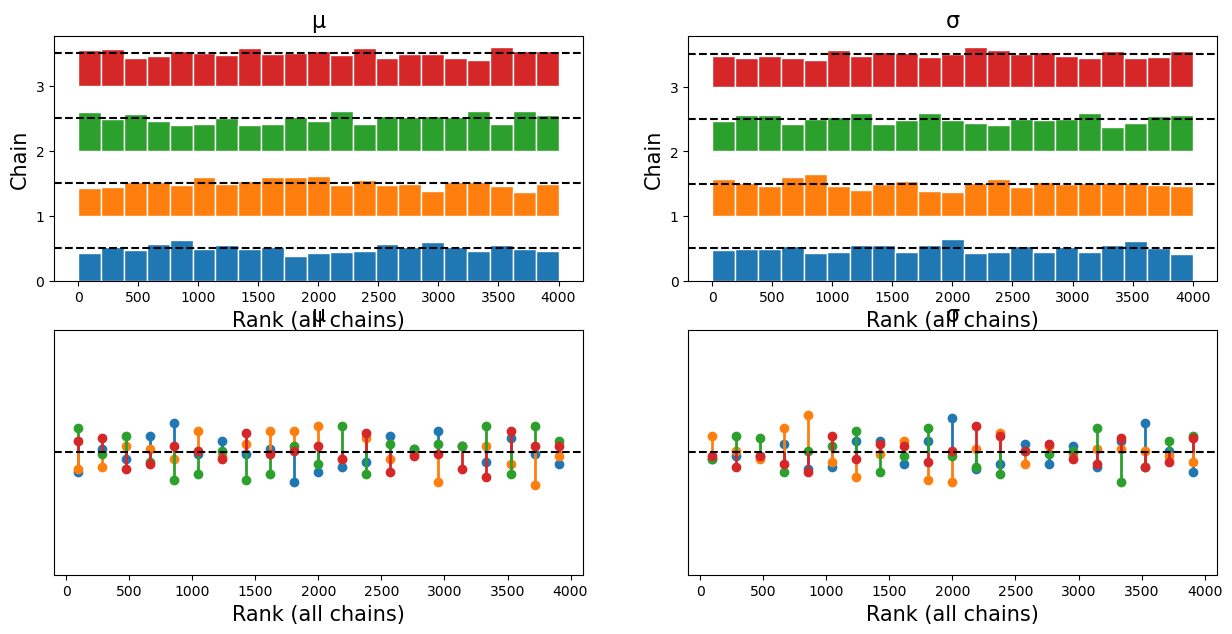

In [17]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(15,7))
az.plot_rank(idata_adelie_mass, kind="bars", ax=ax1);
az.plot_rank(idata_adelie_mass, kind="vlines", ax=ax2);

Результаты моделирования могут быть представлены в виде следующей таблицы:

In [19]:
az.summary(idata_adelie_mass)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3706.801,33.781,3647.389,3772.262,0.513,0.363,4352.0,3193.0,1.0
σ,406.929,20.307,370.779,446.870,0.323,0.230,3988.0,2945.0,1.0


Перевые 4 столбца оцевидны, давайте поговорим об оставшихся. Они относятся к тестам оценивающих качество построения семплов нашей модели.

In [21]:
az.summary(idata_adelie_mass, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.513,0.363,4352.0,3193.0,1.0
σ,0.323,0.230,3988.0,2945.0,1.0


ESS  - эффективный размер выборки. Величина ESS должена быть сопоставима с размером нашей цепочки. ESS это оценка, которая учитывает автокорреляцию и определяет количество сэмплов, которые у нас были бы, если бы наша выборка на самом деле была iid. 

В очень общих условиях методы Марковские цепи Монте-Карло имеют теоретические гарантии того, что они получат правильный ответ независимо от начальной точки. К сожалению, "мелкий шрифт" говорит, что гарантии действительны только для бесконечных образцов. 

Таким образом, на практике нам нужны способы оценки сходимости для конечных образцов. Одна из основных идей заключается в том, чтобы запустить более одной цепочки, начиная с очень разных точек, а затем проверить полученные цепочки, чтобы увидеть, похожи ли они друг на друга. Это интуитивное понятие может быть формализовано в численную диагностику, известную как `r_hat`. 

Существует много версий этого оценщика, так как он совершенствовался на протяжении многих лет. Первоначально диагностика была интерпретирована как завышение дисперсии из-за конечной выборки MCMC. Это означает, что если вы продолжите выборку бесконечно, вы должны получить уменьшение дисперсии вашей оценки на `r_hat`. И отсюда и название «фактор уменьшения потенциального масштаба», с целевым значением 1, что означает, что увеличение количества образцов не уменьшит дисперсию оценки дальше. 
Тем не менее, на практике лучше просто думать об этом как о диагностическом инструменте, не пытаясь это осмыслить.

При использовании методов Марковские цепей Монте-Карло мы вводим дополнительный слой неопределенности, поскольку мы стремимся к истинному к апостериорному распределению с использованием конечным количеством образцов. Мы можем оценить величину данной ошибки с помощью стандартной ошибки Монте-Карло (MCSE), которая основана на теореме центрального предела цепи Маркова. MCSE учитывает, что образцы не являются понастоящему независимыми друг от друга и фактически вычислены из iid выборки. 

Если мы хотим оценить значение некоторого параметра до второго знака после запятой, то нам нужно убедиться, что MCSE ниже второго знака посля запятой, иначе мы будем ошибочно пологать о более высокой точности, чем она у нас есть на самом деле. Мы должны проверить MCSE только после того, как убедимся, что ESS достаточно высок и `r_hut` достаточно близко к 1, в противном случае MCSE бесполезен.

- `mcse_mean` - среднее величина MCSE
- `mcse_sd` - отклонение величиты MCSE
- `ess_bulk` - оценивает насколько, насколько хорошо был определен центр распределения.
- `ess_tail` -  минимальное значению ESS (на концах) в процентилях 5 и 95.
- `r_hat` - фактор уменьшения потенциального масштаба

Ниже показано, как вывести табличку `summary` в LaTeX. Берем и подставляем в ваш отчет в редактор формул World (если вы не умеете пользоваться нормальным текстовым редактором с XeLaTex или LaTeX).

In [24]:
print(az.summary(idata_adelie_mass).round(1).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_3% & hdi_97% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
μ & 3706.800000 & 33.800000 & 3647.400000 & 3772.300000 & 0.500000 & 0.400000 & 4352.000000 & 3193.000000 & 1.000000 \\
σ & 406.900000 & 20.300000 & 370.800000 & 446.900000 & 0.300000 & 0.200000 & 3988.000000 & 2945.000000 & 1.000000 \\
\bottomrule
\end{tabular}



Теперь, когда мы нашли распределение веса пингвинов Adelie, мы можем сделать то же самое для других видов. Можно было бы описать и запустить еще две модели, но вместо этого создадим единую модель с 3 отдельными группами, в зависимости от вида пингвинов.

In [26]:
# метки видов пигвинов
all_species = pd.Categorical(penguins["species"])
coords = {"species": all_species.categories}

with pm.Model(coords=coords) as model_penguin_mass_all_species:
    # Note the addition of the shape parameter
    μ = pm.Normal("μ", 4000, 3000, dims="species")
    σ = pm.HalfStudentT("σ", 100, 2000, dims="species")
    mass = pm.Normal("mass",
                     mu=μ[all_species.codes],
                     sigma=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    idata_penguin_mass_all_species = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


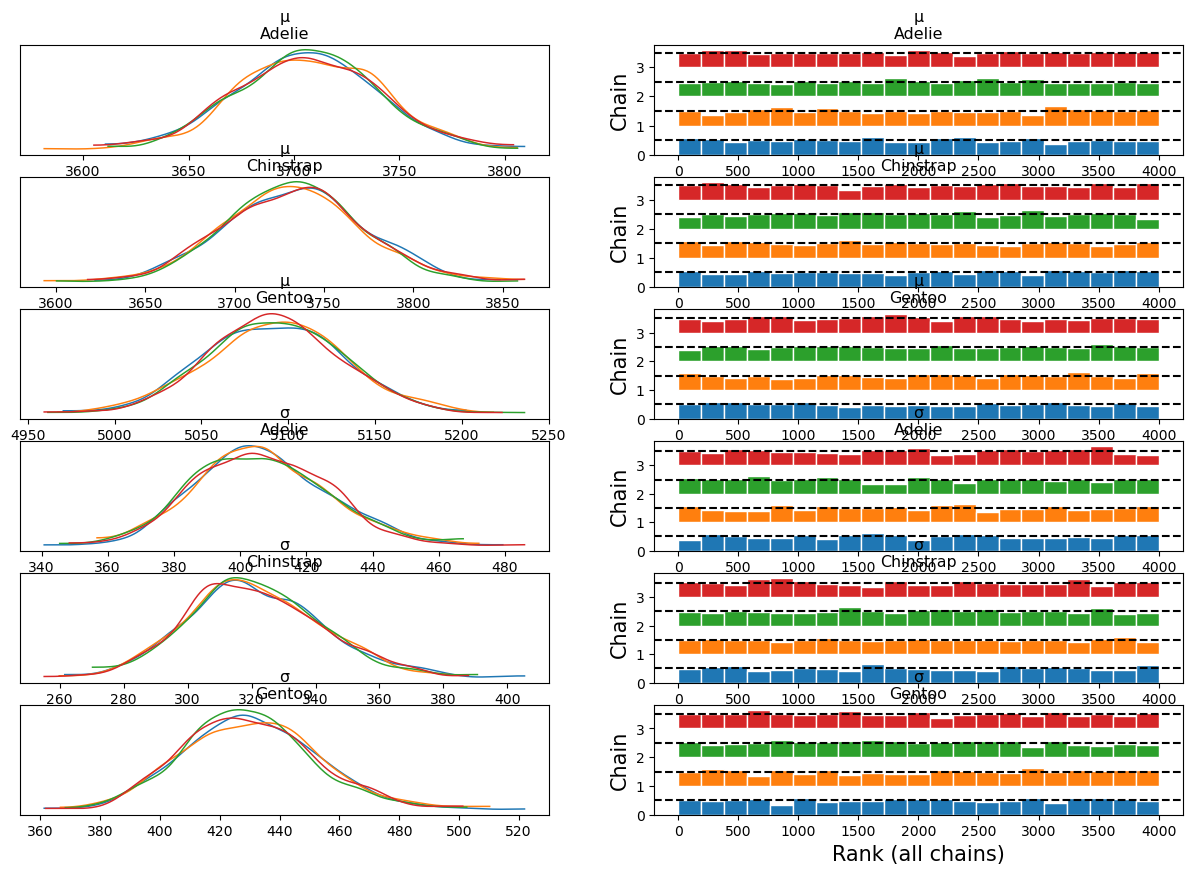

In [27]:
axes = az.plot_trace(idata_penguin_mass_all_species, compact=False,
                     divergences="bottom", kind="rank_bars", figsize=(15, 10),
                     );

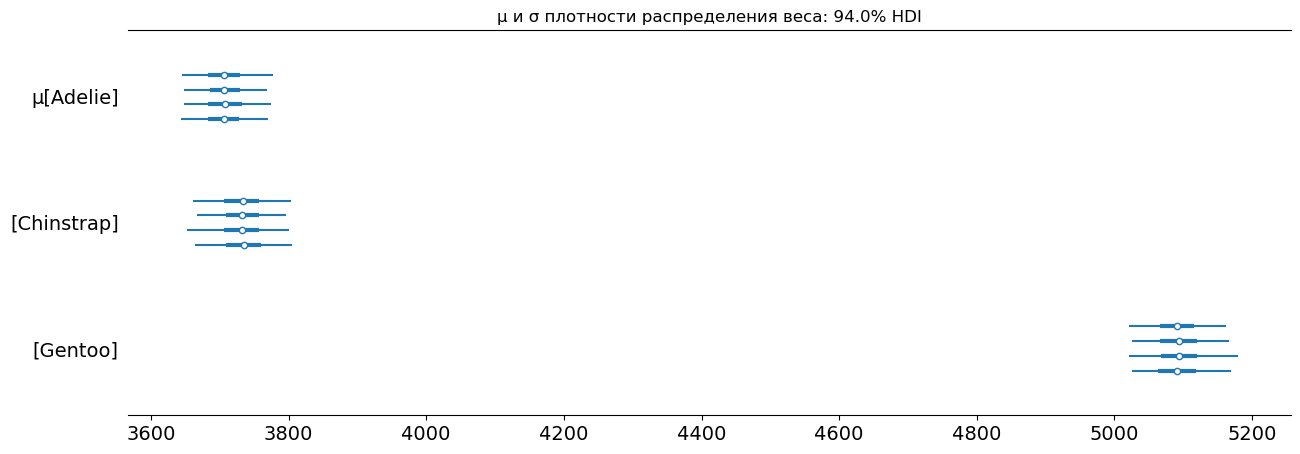

In [28]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["μ"], figsize=(15, 5))
axes[0].set_title("μ и σ плотности распределения веса: 94.0% HDI");

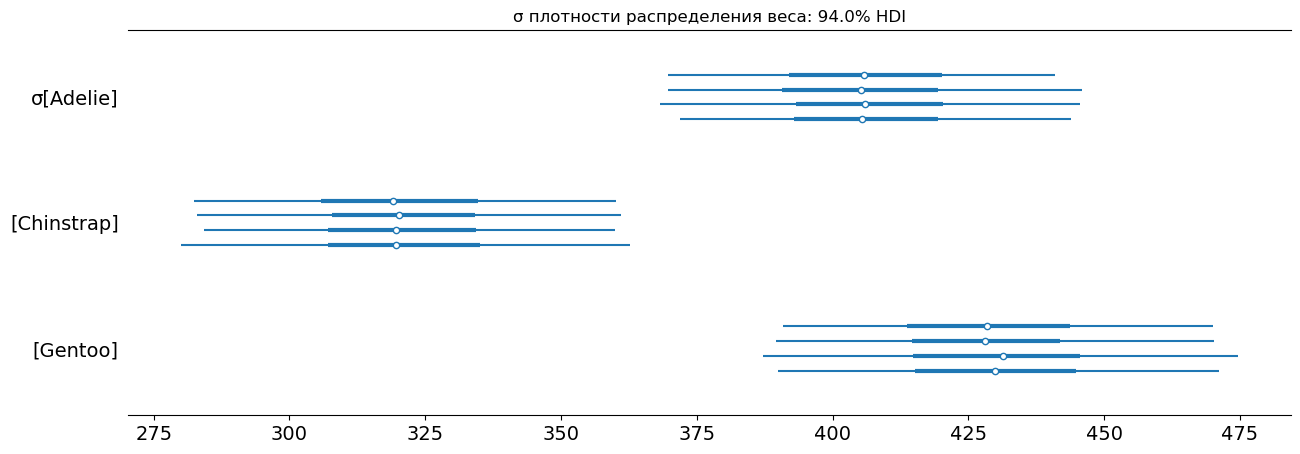

In [29]:
axes = az.plot_forest(idata_penguin_mass_all_species, var_names=["σ"], figsize=(15, 5))
axes[0].set_title("σ плотности распределения веса: 94.0% HDI");

На графиках видны три группы со средним значением веса для каждой группы видов в модели `model_penguin_mass_all_species`. Каждая линия представляет собой одну цепь в семплере, точка - это средняя, толстая линия - это межквартильный диапазон, а тонкая линия - это интервал плотности в 94%.

Графики облегчает сравнение наших оценок и легко отмечает, что пингвины Gentoo имеют большую массу, чем пингвины Adelie или Chinstrap. Посмотрим на величину стандартного отклонения. Интервал с наибольшей плотностью в 94% апостерионого распределения сообщает о неопределенности порядка 100 граммов.

Сохраним результат модели, он нам далее потребуется:

In [32]:
import pickle
# Запись модели
with open('idata_adelie_mass.pkl', 'wb') as f:
     pickle.dump(idata_adelie_mass, f)